# Feature Practice - CWRU

In [1]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np

from scipy import signal, stats
from scipy.signal import hilbert
from scipy.signal import lfilter

In [2]:
import z_dependancy as z_dep

%matplotlib

In [3]:
%matplotlib inline

In [4]:
plt.rc('font', size=20)

In [5]:
fs = 12000;

## 베어링 주파수 DB 만들기

In [6]:
F_BPFI = 5.4152;
F_BPFO = 3.5848;
F_FTF = 0.398;
F_BSF = 4.7135

In [7]:
F_shaft_rpm = 1797; 
F_shaft = F_shaft_rpm/60 

In [8]:
F_BPFI_w = F_BPFI*F_shaft;
F_BPFO_w = F_BPFO*F_shaft;
F_FTF_w = F_FTF*F_shaft;
F_BSF_w = F_BSF*F_shaft;

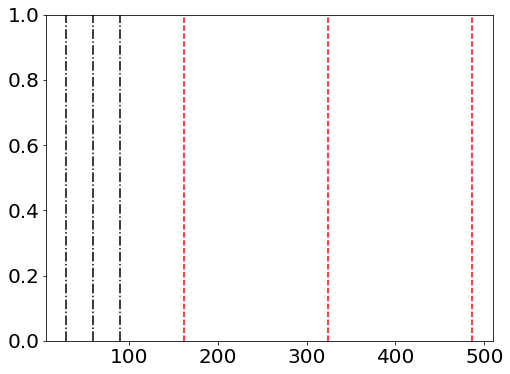

In [9]:
plt.figure(figsize=(8,6))
for n in range(3):
    plt.axvline((n+1)*F_shaft, LineStyle='-.', color='k')
    plt.axvline((n+1)*F_BPFI_w, LineStyle='--', color= 'r')

## 신호 로드하고 그려보기

In [14]:
mat = loadmat('./data/Normal_1797.mat')
v_n=mat['X097_FE_time']
t_n=np.arange(1,len(v_n)+1,1)/fs

In [15]:
mat = loadmat('./data/DE_Outer_0.014_1797.mat')
v_f=mat['X197_DE_time']
t_f=np.arange(1,len(v_f)+1,1)/fs

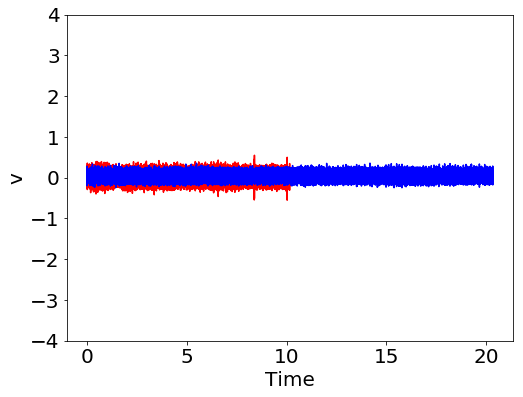

In [16]:
plt.figure(figsize=(8,6))
plt.plot(t_f,v_f,'r')
plt.plot(t_n, v_n,'b')
plt.xlabel('Time');plt.ylabel('v');
plt.ylim([-4,4])
plt.show()

## 주파수 분석해보기

In [17]:
[f_n, A_n] = z_dep.z_fft_simple(v_n,fs);
[f_f, A_f] = z_dep.z_fft_simple(v_f,fs);

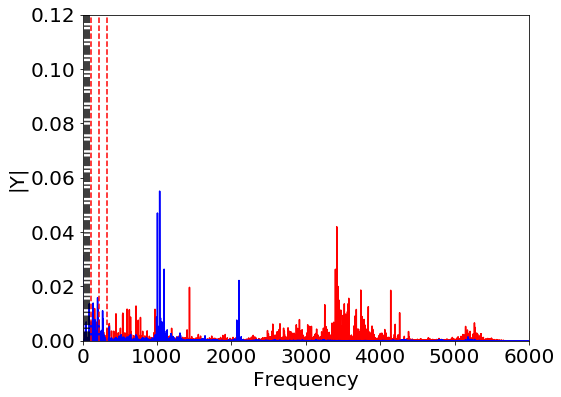

In [18]:
plt.figure(figsize=(8,6))
plt.plot(f_f,A_f,'r')
plt.plot(f_n, A_n, 'b')
plt.xlabel('Frequency');plt.ylabel('|Y|')
plt.ylim([0,0.12])
plt.xlim([0,6000])
for n in range(3):
    plt.axvline((n+1)*F_shaft, LineStyle='-.', color='k')
    plt.axvline((n+1)*F_BPFO_w, LineStyle='--', color= 'r')
plt.show()

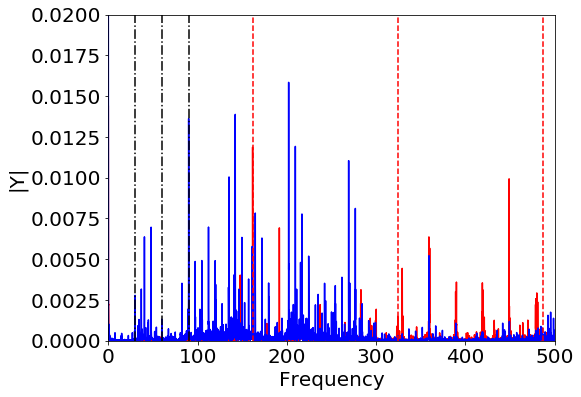

In [19]:
plt.figure(figsize=(8,6))
plt.plot(f_f,A_f,'r')
plt.plot(f_n, A_n, 'b')
plt.xlabel('Frequency');plt.ylabel('|Y|')
plt.ylim([0,0.02])
plt.xlim([0,500])
for n in range(3):
    plt.axvline((n+1)*F_shaft, LineStyle='-.', color='k')
    plt.axvline((n+1)*F_BPFI_w, LineStyle='--', color= 'r')
plt.show()

## Raw Data로 Feature 추출해보기

In [20]:
band=np.matrix([[400,900],
                [2000,4500],
                [4500,5999],
                [F_BPFO_w*0.9, F_BPFO_w*1.1],
                [2*F_BPFO_w*0.9, 2*F_BPFO_w*1.1],
                [3*F_BPFO_w*0.9, 3*F_BPFO_w*1.1]])
print(band)

[[ 400.        900.      ]
 [2000.       4500.      ]
 [4500.       5999.      ]
 [  96.628284  118.101236]
 [ 193.256568  236.202472]
 [ 289.884852  354.303708]]


In [21]:
feature_n, feature_name = z_dep.z_feature_simple(v_n, fs, band)
feature_f,feature_name_f = z_dep.z_feature_simple(v_f, fs, band)
feature_ratio = [i / j for i, j in zip(feature_f, feature_n)]

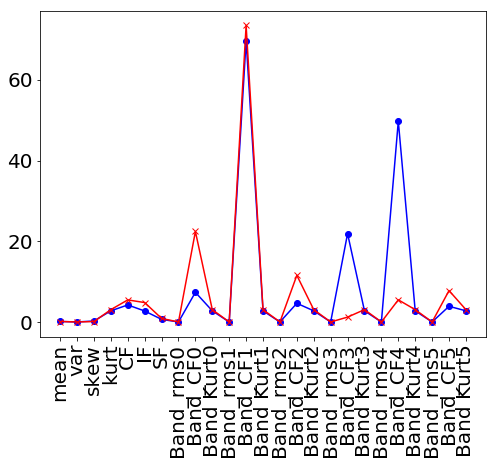

In [22]:
plt.figure(figsize=(8,6))
plt.plot(feature_n,'-bo')
plt.plot(feature_f,'-rx')
plt.xticks(np.arange(0,np.size(feature_name)),feature_name,rotation='vertical');
plt.show()

Text(0, 0.5, 'Feature ratio')

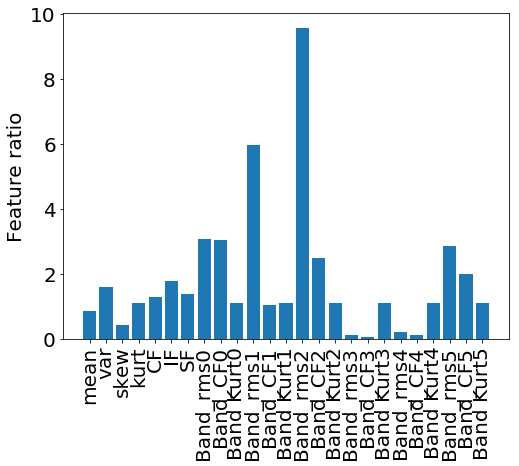

In [23]:
plt.figure(figsize=(8,6))
plt.bar(np.arange(1,np.size(feature_name)+1), feature_ratio)
plt.xticks(np.arange(1,np.size(feature_name)+1),feature_name,rotation='vertical');
plt.ylabel('Feature ratio')

# 포락선 분석해보기

In [24]:
v_env_n = abs(hilbert(v_n,axis=0));
v_env_f = abs(hilbert(v_f,axis=0));

In [25]:
[f_env_n, A_env_n] = z_dep.z_fft_simple(v_env_n-np.mean(v_env_n),fs)
[f_env_f, A_env_f] = z_dep.z_fft_simple(v_env_f-np.mean(v_env_f),fs)

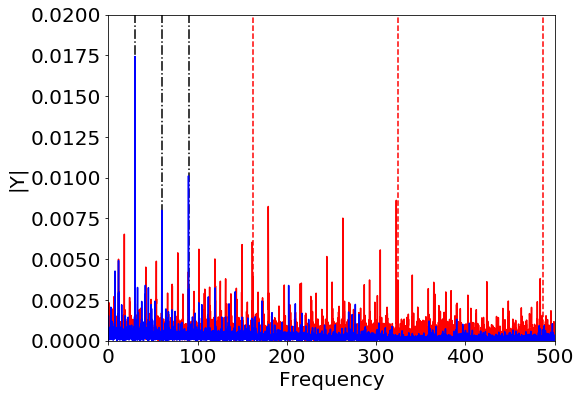

In [26]:
plt.figure(figsize=(8,6))
for n in range(3):
    plt.axvline((n+1)*F_shaft, LineStyle='-.', color='k')
    plt.axvline((n+1)*F_BPFI_w, LineStyle='--', color= 'r')

plt.plot(f_env_f,A_env_f,'r');
plt.plot(f_env_n,A_env_n,'b')
plt.xlabel('Frequency');plt.ylabel('|Y|')
plt.xlim([0,500])
plt.ylim([0,0.02])
plt.show()

# 포락선 데이터로 Feature 추출해보기

In [27]:
feature_env_n,feature_name_n = z_dep.z_feature_simple(v_env_n, fs, band)
feature_env_f,feature_name_f = z_dep.z_feature_simple(v_env_f, fs, band)
feature_env_ratio = [i / j for i, j in zip(feature_env_f, feature_env_n)]

Text(0, 0.5, 'Feature env ratio')

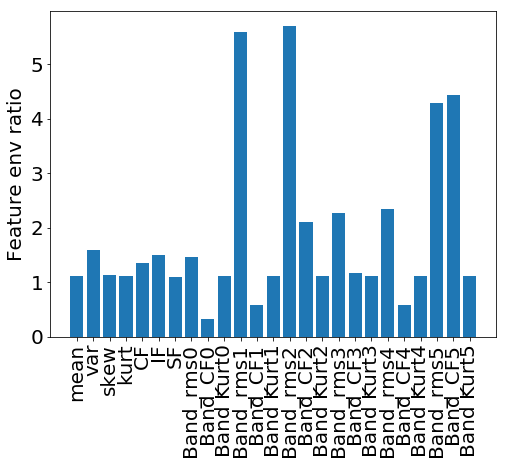

In [28]:
plt.figure(figsize=(8,6))
plt.bar(np.arange(1,np.size(feature_name)+1), feature_env_ratio)
plt.xticks(np.arange(1,np.size(feature_name)+1),feature_name,rotation='vertical');
plt.ylabel('Feature env ratio')

# 필터링 후 분석 해보기

In [29]:
Fn=fs/2
n=4
Wn=2000
ftype='high'
b,a = signal.butter(n,Wn/Fn,btype=ftype,output='ba')

In [30]:
v_high_n=lfilter(b,a,v_n, axis=0);
v_high_f=lfilter(b,a,v_f, axis=0);

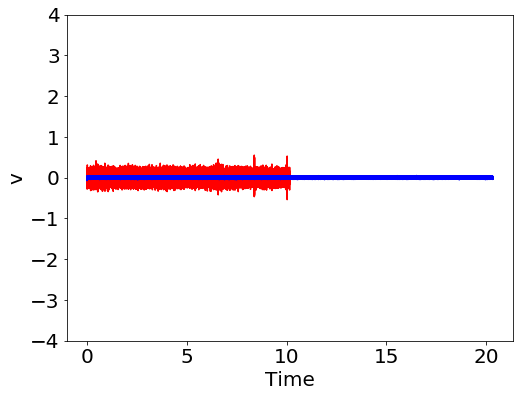

In [31]:
plt.figure(figsize=(8,6))
plt.plot(t_f,v_high_f,'r')
plt.plot(t_n, v_high_n,'b')
plt.xlabel('Time');plt.ylabel('v');
plt.ylim([-4,4])
plt.show()

# 필터링 데이터로 Feature 추출해보기

In [32]:
feature_high_n,tmp_name_n = z_dep.z_feature_simple(v_high_n, fs, band);
feature_high_f,tmp_name_f = z_dep.z_feature_simple(v_high_f, fs, band);
feature_high_ratio = [i / j for i, j in zip(feature_high_f, feature_high_n)]

Text(0, 0.5, 'Feature high ratio')

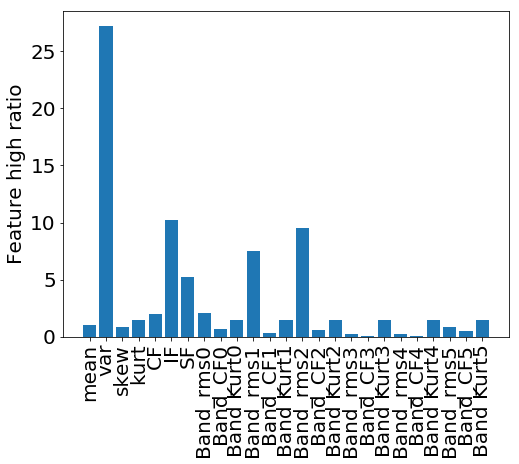

In [33]:
plt.figure(figsize=(8,6))
plt.bar(np.arange(1,np.size(feature_name)+1), feature_high_ratio)
plt.xticks(np.arange(1,np.size(feature_name)+1),feature_name,rotation='vertical');
plt.ylabel('Feature high ratio')

# 필터링 신호에 대해 포락선 분석 해보기

In [34]:
v_high_env_n = abs(hilbert(v_high_n,axis=0));
v_high_env_f = abs(hilbert(v_high_f,axis=0));

In [35]:
[f_high_env_n, A_high_env_n] = z_dep.z_fft_simple(v_high_env_n-np.mean(v_high_env_n),fs);
[f_high_env_f, A_high_env_f] = z_dep.z_fft_simple(v_high_env_f-np.mean(v_high_env_f),fs);

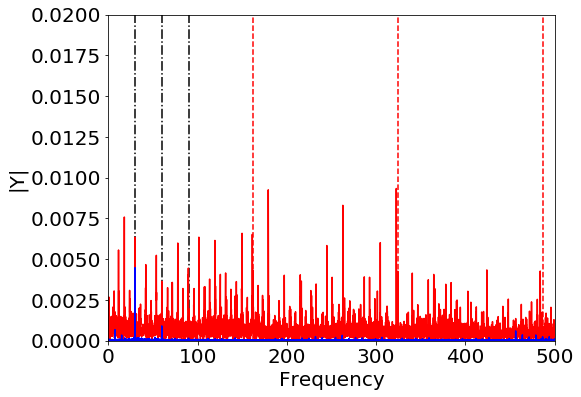

In [36]:
plt.figure(figsize=(8,6))
for n in range(3):
    plt.axvline((n+1)*F_shaft, LineStyle='-.', color='k')
    plt.axvline((n+1)*F_BPFI_w, LineStyle='--', color= 'r')

plt.plot(f_high_env_f,A_high_env_f,'r');
plt.plot(f_high_env_n,A_high_env_n,'b')
plt.xlabel('Frequency');plt.ylabel('|Y|')
plt.xlim([0,500])
plt.ylim([0,0.02])
plt.show()

# 필터링 포락선 데이터로 Feature 추출해보기

In [37]:
feature_high_env_n,tmp_name_n = z_dep.z_feature_simple(v_high_env_n, fs, band)
feature_high_env_f,tmp_name_f = z_dep.z_feature_simple(v_high_env_f, fs, band)
feature_high_env_ratio = [i / j for i, j in zip(feature_high_env_f, feature_high_env_n)]

(-10, 70)

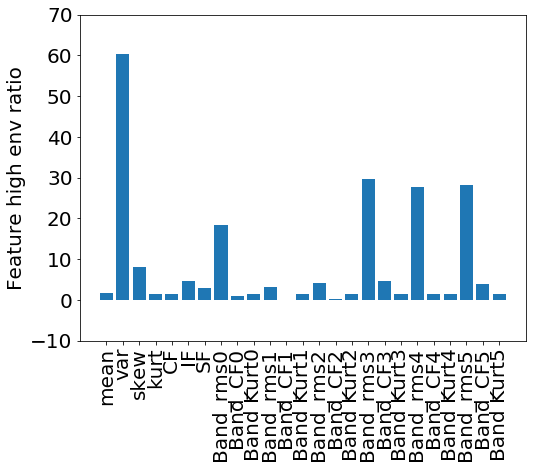

In [38]:
plt.figure(figsize=(8,6))
plt.bar(np.arange(1,np.size(feature_name)+1), feature_high_env_ratio)
plt.xticks(np.arange(1,np.size(feature_name)+1),feature_name,rotation='vertical');
plt.ylabel('Feature high env ratio')
plt.ylim([-10,70])